In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')
import os

In [3]:
output_folder=r"C:\Users\E284652\Documents\repos\pypvcircuit_output"

In [4]:
import unittest
from pypvcell.solarcell import SQCell, MJCell

from pypvcircuit.spice_module_solver import SingleModuleStringSolver, MultiStringModuleSolver
from pypvcell.illumination import load_astm
import pypvcell.fom as fom

import matplotlib.pyplot as plt
import numpy as np

from pypvcircuit.parse_spice_input import NodeReducer

In [5]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

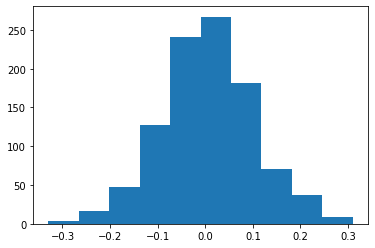

In [6]:
plt.hist(s)
plt.show()

In [7]:
gaas_1j = SQCell(1.42, 300, 1)
ingap_1j = SQCell(1.87, 300, 1)
ge_1j = SQCell(0.7, 300, 1)

mj_cell = MJCell([ingap_1j, gaas_1j, ge_1j])

nd = NodeReducer()

stdev = 0.02

cell_num_array = np.arange(1,20,3)
cell_num_array = np.array([1,2,3,5,10,15,20,])
trial = 30

stdev_array=np.linspace(0.01,0.03,3)

pm_store = np.empty((stdev_array.shape[0],cell_num_array.shape[0], trial))
isc_store = np.empty((stdev_array.shape[0],cell_num_array.shape[0], trial))
voc_store = np.empty((stdev_array.shape[0],cell_num_array.shape[0], trial))
ff_store = np.empty((stdev_array.shape[0],cell_num_array.shape[0], trial))

for stdev_index, stdev_a in enumerate(stdev_array):

    for std_index, cell_num in enumerate(cell_num_array):

        for tt in range(trial):
            test_string_num=5
            
            stdev=float(stdev_a)
            sm = MultiStringModuleSolver(solarcell=mj_cell, illumination=500,
                                         v_start=0, v_end=3.5 * cell_num, v_steps=0.05, l_r=1e-3, l_c=1e-3,
                                         cell_number=cell_num, string_number=test_string_num, isc_stdev=stdev,
                                         spice_preprocessor=None)

            # print(sm._generate_network())

            sm._solve_circuit()
            calc_isc=fom.isc(sm.V, sm.I)/test_string_num
            max_p = fom.max_power(sm.V, sm.I) / (cell_num * test_string_num)
            voc_p=fom.voc(sm.V,sm.I)/cell_num
            ff_p=fom.ff(sm.V,sm.I)
            plt.plot(sm.V,sm.I)
            plt.ylim(top=0)

            fname="{}_{}.png".format(std_index,tt)

            plt.savefig(os.path.join(output_folder,fname))
            plt.close()


            pm_store[stdev_index,std_index, tt] = max_p
            isc_store[stdev_index,std_index,tt] = calc_isc
            voc_store[stdev_index,std_index,tt]=voc_p
            ff_store[stdev_index,std_index,tt]=ff_p

In [8]:
from pypvcell.illumination import load_astm
mj_cell.set_input_spectrum(load_astm("AM1.5g")*500)

In [9]:
normal_p=mj_cell.get_eta()*1e-6*500*1000
normal_p

0.23228764743850291

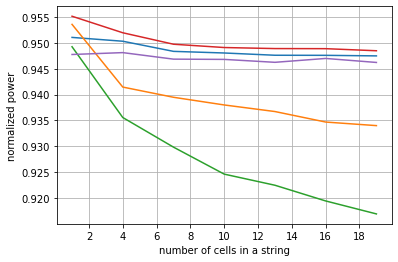

In [10]:
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(cell_num_array, pm_store[0,:,:].mean(axis=1)/normal_p)
ax.plot(cell_num_array, pm_store[1,:,:].mean(axis=1)/normal_p)
ax.plot(cell_num_array, pm_store[2,:,:].mean(axis=1)/normal_p)
#plt.plot(cell_num_array, pm_store.max(axis=1)/normal_p)
ax.plot(cell_num_array, np.percentile(pm_store[0,:,:]/normal_p,75,axis=1))
ax.plot(cell_num_array, np.percentile(pm_store[0,:,:]/normal_p,25,axis=1))

#plt.axhline(1.0)
ax.set_xlabel("number of cells in a string")
ax.set_ylabel("normalized power")
plt.grid()
plt.show()

In [21]:
## Draw violin plot

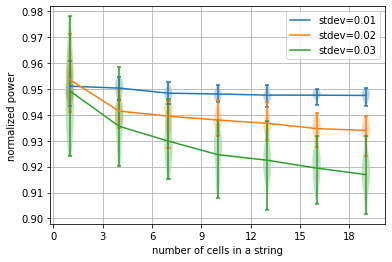

In [54]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.violinplot(pm_store[0,:,:].T/normal_p,positions=cell_num_array)
ax.violinplot(pm_store[1,:,:].T/normal_p,positions=cell_num_array)
ax.violinplot(pm_store[2,:,:].T/normal_p,positions=cell_num_array)
for idx, stdev in enumerate(stdev_array):
    ax.plot(cell_num_array, pm_store[idx,:,:].mean(axis=1)/normal_p,color='C{}'.format(idx),label="stdev={:.2f}".format(stdev))

ax.grid()
ax.set_xlabel("number of cells in a string")
ax.set_ylabel("normalized power")
ax.legend()
plt.savefig("power_vs_strings.png",dpi=300)
plt.show()

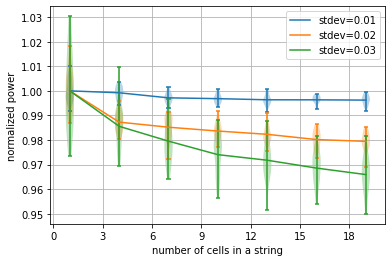

In [58]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.violinplot(pm_store[0,:,:].T/np.mean(pm_store[0,0,:]),positions=cell_num_array)
ax.violinplot(pm_store[1,:,:].T/np.mean(pm_store[1,0,:]),positions=cell_num_array)
ax.violinplot(pm_store[2,:,:].T/np.mean(pm_store[2,0,:]),positions=cell_num_array)
for idx, stdev in enumerate(stdev_array):
    ax.plot(cell_num_array, pm_store[idx,:,:].mean(axis=1)/np.mean(pm_store[idx,0,:]),color='C{}'.format(idx),label="stdev={:.2f}".format(stdev))

ax.grid()
ax.set_xlabel("number of cells in a string")
ax.set_ylabel("normalized power")
ax.legend()
plt.savefig("power_vs_strings.png",dpi=300)
plt.show()

Text(0, 0.5, 'occurrences')

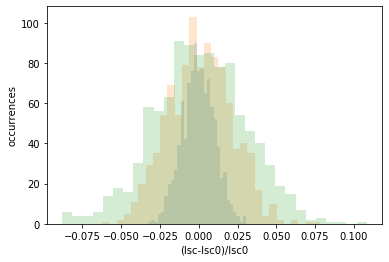

In [57]:
for idx, stdev in enumerate(stdev_array):
    a=np.random.normal(0, stdev, 1000)
    plt.hist(a,alpha=0.2,bins=30, label="{:.2f}".format(stdev))
plt.xlabel("(Isc-Isc0)/Isc0")
plt.ylabel("occurrences")

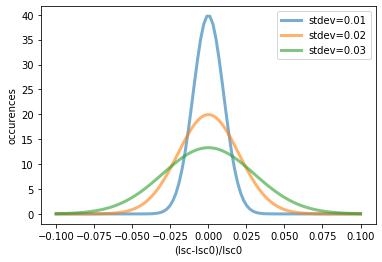

In [55]:
from scipy.stats import norm
ax = plt.figure().gca()

for idx, stdev in enumerate(stdev_array):
    x = np.linspace(-0.1,
                 0.1, 100)
    pdf=scipy.stats.norm.pdf(x,0,stdev)
    ax.plot(x, pdf,
         lw=3, alpha=0.6, label='stdev={:.2f}'.format(stdev))

ax.legend()
ax.set_xlabel("(Isc-Isc0)/Isc0")
ax.set_ylabel("occurences")

plt.savefig("Isc_distribution.png",dpi=300)
    

ValueError: x and y must have same first dimension, but have shapes (7,) and (3, 30)

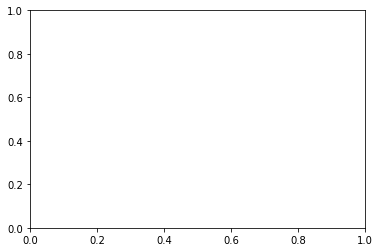

In [48]:
plt.plot(cell_num_array, -isc_store.mean(axis=1))
plt.plot(cell_num_array, np.percentile(-isc_store,75,axis=1))
plt.plot(cell_num_array, np.percentile(-isc_store,25,axis=1))

#plt.axhline(1.0)
plt.xlabel("number of cells in a string")
plt.ylabel("normalized Isc")
plt.grid()
plt.show()

In [ ]:
plt.plot(cell_num_array, voc_store.mean(axis=1))
plt.plot(cell_num_array, voc_store.max(axis=1))
plt.plot(cell_num_array, voc_store.min(axis=1))
plt.show()

In [ ]:
plt.plot(cell_num_array, ff_store.mean(axis=1))
plt.plot(cell_num_array, ff_store.max(axis=1))
plt.plot(cell_num_array, ff_store.min(axis=1))
plt.show()